### Trip advisor LSTM model on full data for HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('all')


import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.

### Reading the data

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/Trip Advisor Project/TripAdvisor_Text_Reviews.csv")
df.head(2)

,User_Name,Contributions,Title,Review,Date_of_Stay,Heading
0,reema,"Riyadh, Saudi Arabia;1 contribution",['Nice'],"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",Date of stay: June 2023,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City
1,jcmtl1965,"Montreal, Canada;8939 contributions;8939;100 helpful votes",['Nice stay for my return to New York'],I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,Date of stay: August 2021,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City


### Data Shape and Info

In [6]:
df.shape
print("Data has {} rows".format(df.shape[0]))
print("Data has {} Columns". format(df.shape[1]))

Data has 82386 rows
Data has 6 Columns


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82386 entries, 0 to 82385
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Name      82386 non-null  object
 1   Contributions  82184 non-null  object
 2   Title          82386 non-null  object
 3   Review         82386 non-null  object
 4   Date_of_Stay   82247 non-null  object
 5   Heading        82386 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB


### Data Null Values

In [8]:
df_null = df.isnull().sum().to_frame("count").sort_values(by="count", ascending = False)
df_null

,count
Contributions,202
Date_of_Stay,139
User_Name,0
Title,0
Review,0
Heading,0


### Visualize the Null Values

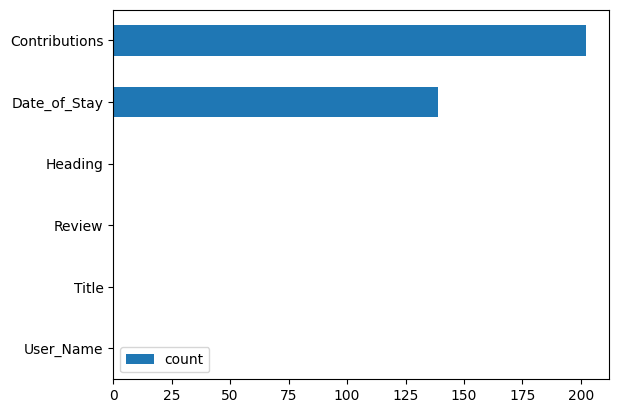

In [9]:
df_null.sort_values(by="count", ascending = True).plot(kind="barh")
plt.show()

### Extracting the helpfulness of the column

In [10]:
df1 = df.copy()
df1['Helpfulness'] = df['Contributions'].str.extract(r'\b(helpful)\b')
df1.head(2)

,User_Name,Contributions,Title,Review,Date_of_Stay,Heading,Helpfulness
0,reema,"Riyadh, Saudi Arabia;1 contribution",['Nice'],"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",Date of stay: June 2023,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City,NaN
1,jcmtl1965,"Montreal, Canada;8939 contributions;8939;100 helpful votes",['Nice stay for my return to New York'],I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,Date of stay: August 2021,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City,helpful


### Label the data as Helpful and Not Helpful

In [11]:
# Fill NaN values with "not helpful"
df2 = df1.copy()
df2 = df1.fillna("not helpful")
df2.head(3)

,User_Name,Contributions,Title,Review,Date_of_Stay,Heading,Helpfulness
0,reema,"Riyadh, Saudi Arabia;1 contribution",['Nice'],"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",Date of stay: June 2023,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City,not helpful
1,jcmtl1965,"Montreal, Canada;8939 contributions;8939;100 helpful votes",['Nice stay for my return to New York'],I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,Date of stay: August 2021,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City,helpful
2,Erin M,1 contribution,['Wonderful'],Had a wonderful experience from entrance to exit! Need to shoutout Nakita and Luigi who gave me such a warm welcome and answered all questions I had! They are such a wonderful team. Looking forward to the next visit!,Date of stay: June 2023,HILTON GARDEN INN NYC FINANCIAL CENTER / MANHATTAN DOWNTOWN $135 ($̶3̶7̶7̶) - Updated 2023 Prices & Hotel Reviews - New York City,not helpful


In [12]:
df3 = df2[["Contributions", "Title","Review", "Helpfulness"]]
df3.head(2)

,Contributions,Title,Review,Helpfulness
0,"Riyadh, Saudi Arabia;1 contribution",['Nice'],"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",not helpful
1,"Montreal, Canada;8939 contributions;8939;100 helpful votes",['Nice stay for my return to New York'],I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,helpful


### Checking the Datatypes

In [13]:
# using dictionary to convert specific columns
df3 = df3[['Contributions','Title','Review',"Helpfulness"]].astype(str)
print(df3.dtypes)

Contributions    object
Title            object
Review           object
Helpfulness      object
dtype: object


In [14]:
if pd.api.types.is_string_dtype(df3['Helpfulness']):
    print("Helpfulness is of string datatype.")

if pd.api.types.is_string_dtype(df3['Contributions']):
    print("Contributions is of string datatype.")

if pd.api.types.is_string_dtype(df3['Title']):
    print("Title is of string datatype.")


Helpfulness is of string datatype.
Contributions is of string datatype.
Title is of string datatype.


### Visualize the target class distribution

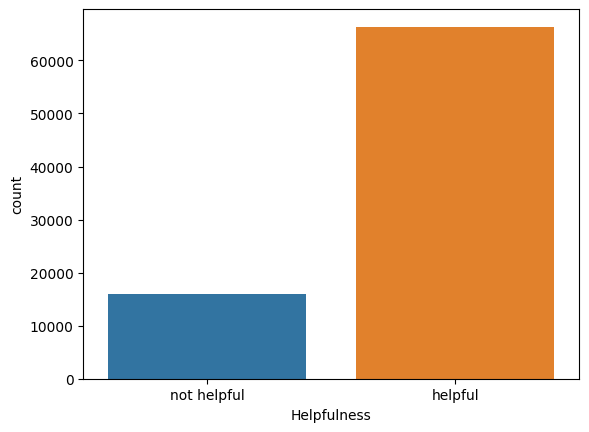

In [15]:
# importing the required library

import seaborn as sns
import matplotlib.pyplot as plt

# count plot on single categorical variable
sns.countplot(x ='Helpfulness', data = df3)

# Show the plot
plt.show()

### Pie chart

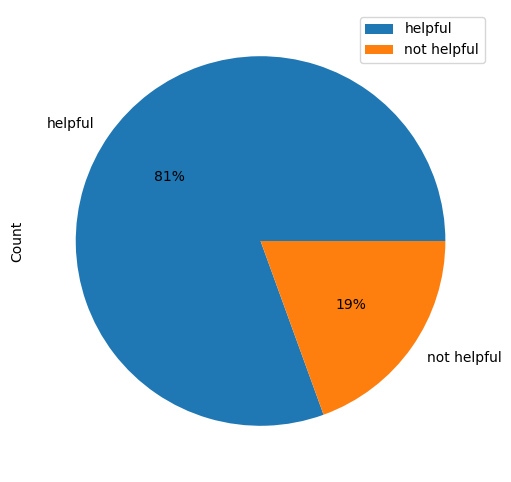

In [16]:
df3['Helpfulness'].value_counts().to_frame("Count").plot(kind='pie', y='Count', autopct='%1.0f%%', legend= True, figsize = (6,6))
plt.show()

### Visualize the word cloud of the Reviews

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


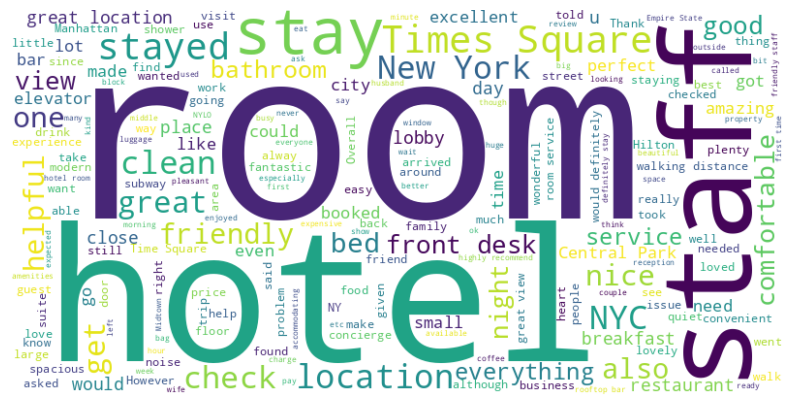

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Download the nltk stopwords if you haven't done so
nltk.download('stopwords')

# Create a set of stopwords
stop_words = set(stopwords.words('english'))

# visualize the frequent words
text = " ".join([sentence for sentence in df3['Review']])

# Generate a word cloud with stop words
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text)

# plot the graph
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Mapping the Helpful column to numeric values: Helpful =1, not helpful = 0

In [18]:
map = { "helpful" : 1,
       "not helpful":0}

df4 = df3.copy()
df4['Helpful'] = df4['Helpfulness'].map(map)
df4.head(2)

,Contributions,Title,Review,Helpfulness,Helpful
0,"Riyadh, Saudi Arabia;1 contribution",['Nice'],"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",not helpful,0
1,"Montreal, Canada;8939 contributions;8939;100 helpful votes",['Nice stay for my return to New York'],I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,helpful,1


### Preparing the final dataframe

In [19]:
df5 = df4[["Review", "Helpful"]]
df5.head(2)

,Review,Helpful
0,"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",0
1,I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,1


# Text Preprocessing

In [20]:
import nltk
import re

# import package and its set of stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_nltk = set(nltk.corpus.stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cleaned data

In [22]:
df5["Clean_review"] = df5["Review"].apply(clean_text)
df5.head()

<ipython-input-22-c0b00b2480d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5["Clean_review"] = df5["Review"].apply(clean_text)


,Review,Helpful,Clean_review
0,"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality
1,I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay
2,Had a wonderful experience from entrance to exit! Need to shoutout Nakita and Luigi who gave me such a warm welcome and answered all questions I had! They are such a wonderful team. Looking forward to the next visit!,0,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit
3,"This was my 2nd time staying at this location for just one night. Just like my first visit, the check in was super quick, easy, and very pleasant. Room was perfect, clean, and quiet. Super location for finding 3-4 subway stops. I will be back.",0,nd time staying location one night like first visit check super quick easy pleasant room perfect clean quiet super location finding subway stops back
4,"We were wonderfully greeted by Nakita, Wanda and Luigi as we checked in at the hotel! We had a great stay at this hotel as the rooms were clean, showers had decent pressure and it was very easy for us to travel around the city as it was very close to multiple subway stations. We interacted with Nakita many times throughout our trip and she was truly so kind, caring and accommodating! We had a great stay and would love to stay here again in the future!",0,wonderfully greeted nakita wanda luigi checked hotel great stay hotel rooms clean showers decent pressure easy us travel around city close multiple subway stations interacted nakita many times throughout trip truly kind caring accommodating great stay would love stay future


### Tokens frequency distribution:

In [23]:
import collections
from collections import Counter
from itertools import chain

# Tokenize the text column
df5['Tokenized_Text'] = df5['Clean_review'].apply(word_tokenize)

# Print the tokenized text
corpus = df5['Tokenized_Text']
corpus = corpus.tolist()
# Flatten list of lists to a single list
tokens = list(chain(*corpus))
unique_freq = collections.Counter(tokens)
# Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
# Rename columns
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'})
# Sort by count
unique_freq_df.sort_values('count', ascending=False, inplace=True)
unique_freq_df = unique_freq_df.head(20)

unique_freq_df1 = unique_freq_df.reset_index(drop=True)
unique_freq_df2 = unique_freq_df1.set_index("token")
unique_freq_df2

<ipython-input-23-b2b067e61b85>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Tokenized_Text'] = df5['Clean_review'].apply(word_tokenize)


,count
token,
hotel,97726
room,85143
great,47081
staff,41688
location,39353
stay,36903
rooms,32550
good,26205
times,25896


### Visualize the token frequency distribution

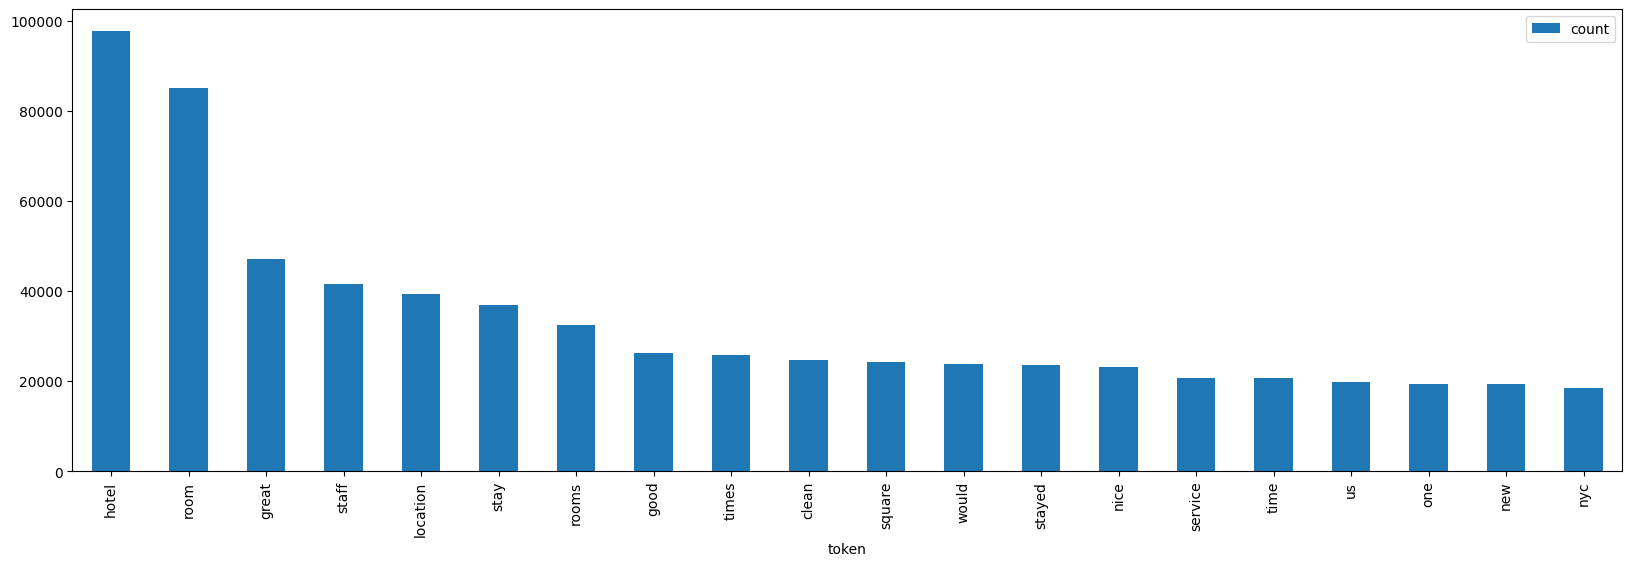

In [24]:
unique_freq_df2.plot(kind="bar", figsize= (20,6), grid=False)
plt.show()

## Feature Extraction with TF IDF

In [25]:
df5.head(2)

,Review,Helpful,Clean_review,Tokenized_Text
0,"Nice experience in the hotel for anyone who would like to stay in NYC. It is near the World Trade Center. I will choose it if I come again to NYC. Also, Special thanks to Mr.Luigi & Mr.An & Ms.Nakita for their kindness and their nice hospitality.",0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,"[nice, experience, hotel, anyone, would, like, stay, nyc, near, world, trade, center, choose, come, nyc, also, special, thanks, mrluigi, mran, msnakita, kindness, nice, hospitality]"
1,I hadn't been to New York in 22 months (which is really long for me). I decided to stay away from Midtown so picked this hotel in the financial district. The personnel was really nice and helpful. I had few needs and did not require the room clean but they provided me with anything I requested. They were also very helpful with the subway system. Because of Hurricane Henri my flight was cancelled and they were very accommodating with giving me an extra night in the same room. I really enjoyed my stay,1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,"[hadnt, new, york, months, really, long, decided, stay, away, midtown, picked, hotel, financial, district, personnel, really, nice, helpful, needs, require, room, clean, provided, anything, requested, also, helpful, subway, system, hurricane, henri, flight, cancelled, accommodating, giving, extra, night, room, really, enjoyed, stay]"


In [26]:
# TF-IDF feature extraction

tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df5['Clean_review'])

# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame from the feature names
df_tfidf = pd.DataFrame({'Feature Name': feature_names})

# Print the DataFrame
df_tfidf.to_csv("TF_IDF_Fulldata.csv")

len(df_tfidf)

df_tfidf.head(10)

,Feature Name
0,aa
1,aaa
2,aaaaa
3,aaaaarp
4,aaaahhhh
5,aaaamazing
6,aaahhhuummm
7,aaargh
8,aable
9,aacap


# LSTM Model

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [28]:

X = df5['Clean_review']
y = df5['Helpful']

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Create sequences
sequences = tokenizer.texts_to_sequences(X)

# Create word index
word_index = tokenizer.word_index

# Pad sequences
X_padded = pad_sequences(sequences, padding='post', maxlen=50)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2)

In [29]:
print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

Shape of training tensor:  (65908, 50)
Shape of testing tensor:  (16478, 50)


In [93]:
# Create the LSTM model


# Define parameter
vocab_size = 1000
embedding_dim = 100
max_len = 50

# Define Dense Model Architecture
model1 = Sequential()
model1.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_len))
model1.add(layers.LSTM(units=128,return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model1.add(layers.LSTM(units=64, return_sequences=True))
model1.add(layers.LSTM(units=28))
model1.add(layers.Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           5884500   
                                                                 
 lstm_19 (LSTM)              (None, 50, 128)           117248    
                                                                 
 lstm_20 (LSTM)              (None, 50, 64)            49408     
                                                                 
 lstm_21 (LSTM)              (None, 28)                10416     
                                                                 
 dropout_11 (Dropout)        (None, 28)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 29        
                                                                 
Total params: 6,061,601
Trainable params: 6,061,601
No

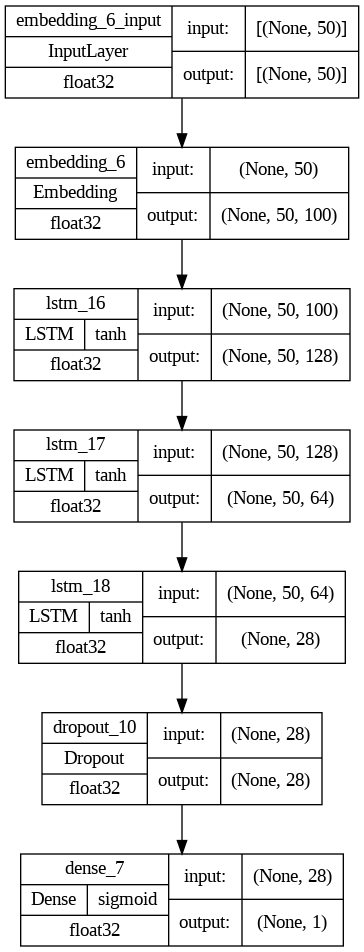

In [80]:
tf.keras.utils.plot_model(
	model1,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

In [94]:
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)  # Early stopping to prevent overfitting
history1 = model1.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping], shuffle =True)

Epoch 1/10
1648/1648 [==============================] - 153s 90ms/step - loss: 0.4800 - accuracy: 0.8088 - val_loss: 0.4396 - val_accuracy: 0.8031
Epoch 2/10
1648/1648 [==============================] - 148s 90ms/step - loss: 0.4084 - accuracy: 0.8221 - val_loss: 0.4456 - val_accuracy: 0.8085
Epoch 3/10
1648/1648 [==============================] - 148s 90ms/step - loss: 0.3774 - accuracy: 0.8363 - val_loss: 0.4621 - val_accuracy: 0.8012
Epoch 4/10
1648/1648 [==============================] - 147s 89ms/step - loss: 0.3524 - accuracy: 0.8503 - val_loss: 0.4686 - val_accuracy: 0.7934


In [95]:
from tensorflow.python import training

# Evaluate the model
loss_train, accuracy_train = model1.evaluate(X_train, y_train, verbose=False)
loss_test, accuracy_test = model1.evaluate(X_test, y_test, verbose=False)

print("Training loss:", loss_train)
print("Training accuracy:", accuracy_train)
print("Testing loss:", loss_test)
print("Testing accuracy:", accuracy_test)

Training loss: 0.40820416808128357
Training accuracy: 0.8199156522750854
Testing loss: 0.4480215311050415
Testing accuracy: 0.7981551289558411


In [219]:
evaluation_results = {
    'Model': ['Lstm_Train', 'Lstm_Test'],
    'Loss': [loss_train, loss_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

import pandas as pd

results_df1 = pd.DataFrame(evaluation_results)
results_df1

,Model,Loss,Accuracy
0,Lstm_Train,0.379144,0.829596
1,Lstm_Test,0.482268,0.803131


## Plot model accuracy and loss

In [97]:
metrics1 = pd.DataFrame(history1.history)
metrics1

,loss,accuracy,val_loss,val_accuracy
0,0.480041,0.808804,0.439557,0.803065
1,0.408353,0.822061,0.445580,0.808527
2,0.377428,0.836343,0.462150,0.801168
3,0.352425,0.850321,0.468627,0.793355


In [98]:
# Rename column
metrics1.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics1

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.480041,0.808804,0.439557,0.803065
1,0.408353,0.822061,0.445580,0.808527
2,0.377428,0.836343,0.462150,0.801168
3,0.352425,0.850321,0.468627,0.793355


## Loss

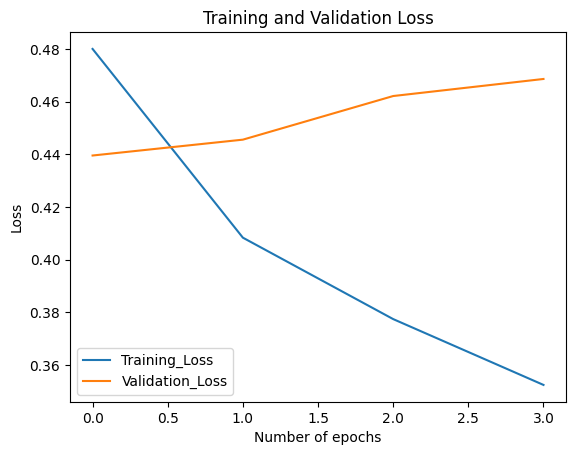

In [99]:
metrics1[["Training_Loss", "Validation_Loss"]].plot()
plt.title('Training and Validation Loss')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

### Accuracy

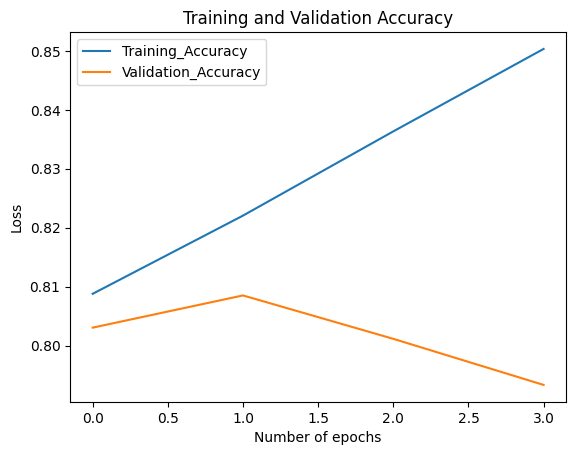

In [100]:
metrics1[["Training_Accuracy", "Validation_Accuracy"]].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

# Predict using LSTM on train data

In [101]:
# display long string
pd.options.display.max_colwidth=1000
df6 =df5[["Clean_review", "Helpful"]]
df6.head()

,Clean_review,Helpful
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0
3,nd time staying location one night like first visit check super quick easy pleasant room perfect clean quiet super location finding subway stops back,0
4,wonderfully greeted nakita wanda luigi checked hotel great stay hotel rooms clean showers decent pressure easy us travel around city close multiple subway stations interacted nakita many times throughout trip truly kind caring accommodating great stay would love stay future,0


In [105]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 1000

In [106]:
predict_msg = df6["Clean_review"]

new_seq = tokenizer.texts_to_sequences(predict_msg)

new_seq = pad_sequences(new_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type)

df6["ypred"] = model1.predict(new_seq).reshape(-1, 1)

df6.head(3)

2575/2575 [==============================] - 64s 25ms/step


,Clean_review,Helpful,ypred,pred_label
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0,0.452928,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1,0.793461,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0,0.440041,0


In [107]:
import numpy as np

df6["pred_label"] = np.where(df6["ypred"] > 0.5 , 1, 0)
df6.head()

,Clean_review,Helpful,ypred,pred_label
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0,0.452928,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1,0.793461,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0,0.440041,0
3,nd time staying location one night like first visit check super quick easy pleasant room perfect clean quiet super location finding subway stops back,0,0.469202,0
4,wonderfully greeted nakita wanda luigi checked hotel great stay hotel rooms clean showers decent pressure easy us travel around city close multiple subway stations interacted nakita many times throughout trip truly kind caring accommodating great stay would love stay future,0,0.445137,0


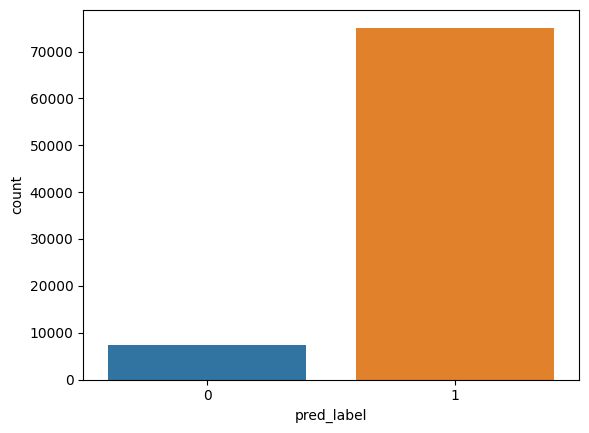

In [108]:
sns.countplot(x="pred_label", data=df6)
plt.show()

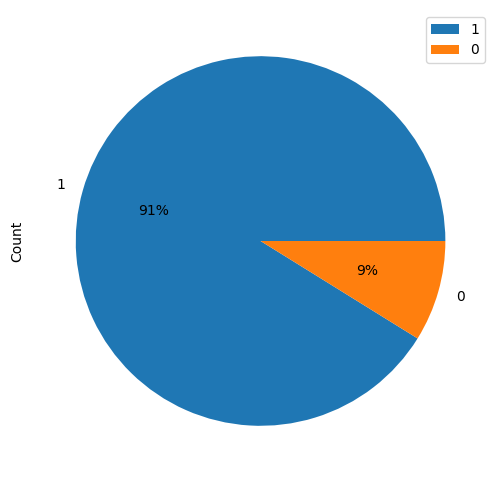

In [109]:
df6['pred_label'].value_counts().to_frame("Count").plot(kind='pie', y='Count', autopct='%1.0f%%', legend= True, figsize = (6,6))
plt.show()

## Bi-LSTM Model

In [ ]:
# Step 3: Build the Bi-LSTM model
embedding_dim = 100  # You can adjust this value based on your word embeddings
max_len = 50


num_classes = len(np.unique(y))
num_classes

2

In [111]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [127]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
model2.add(Bidirectional(LSTM(units=64)))
model2.add(Dense(24, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' activation for binary classification
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 100)           5884500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 24)                3096      
                                                                 
 dropout_13 (Dropout)        (None, 24)                0         
                                                                 
 dense_12 (Dense)            (None, 1)               

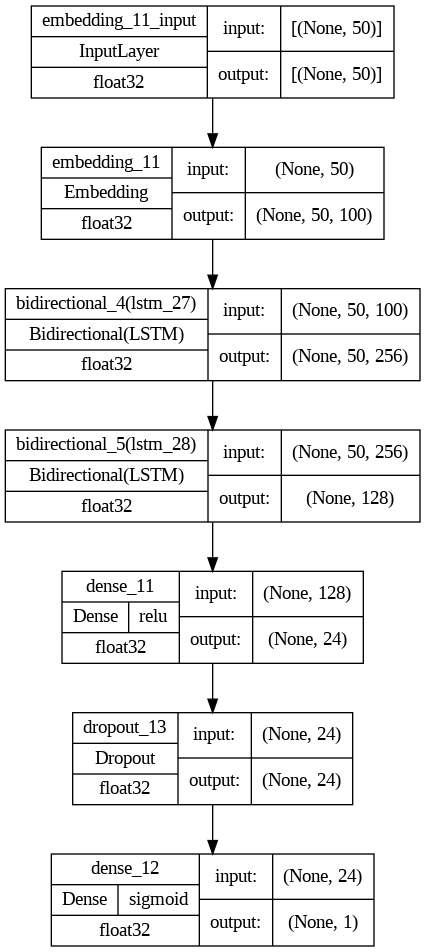

In [128]:
import tensorflow as tf  # Import tensorflow

tf.keras.utils.plot_model(
	model2,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

# Bi-Lstm Model training

In [129]:
early_stopping = EarlyStopping(patience=2, restore_best_weights=True)  # Early stopping to prevent overfitting
history2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping], shuffle=True)

Epoch 1/20
1648/1648 [==============================] - 145s 84ms/step - loss: 0.5096 - accuracy: 0.8104 - val_loss: 0.4445 - val_accuracy: 0.8022
Epoch 2/20
1648/1648 [==============================] - 136s 82ms/step - loss: 0.4092 - accuracy: 0.8223 - val_loss: 0.4448 - val_accuracy: 0.8068
Epoch 3/20
1648/1648 [==============================] - 137s 83ms/step - loss: 0.3783 - accuracy: 0.8354 - val_loss: 0.4728 - val_accuracy: 0.8058


In [130]:
from tensorflow.python import training

# Evaluate the model
loss_train, accuracy_train = model2.evaluate(X_train, y_train, verbose=False)
loss_test, accuracy_test = model2.evaluate(X_test, y_test, verbose=False)

print("Training loss:", loss_train)
print("Training accuracy:", accuracy_train)
print("Testing loss:", loss_test)
print("Testing accuracy:", accuracy_test)

Training loss: 0.40591588616371155
Training accuracy: 0.8221156597137451
Testing loss: 0.4504401981830597
Testing accuracy: 0.7974268794059753


In [227]:
evaluation_results = {
    'Model': ['Bilstm_Train', 'Bilstm_Test'],
    'Loss': [loss_train, loss_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

import pandas as pd

results_df2 = pd.DataFrame(evaluation_results)
results_df2

,Model,Loss,Accuracy
0,Bilstm_Train,0.438247,0.807474
1,Bilstm_Test,0.461621,0.797063


In [132]:
metrics2 = pd.DataFrame(history2.history)
metrics2

,loss,accuracy,val_loss,val_accuracy
0,0.509646,0.810416,0.444468,0.802230
1,0.409209,0.822327,0.444814,0.806782
2,0.378291,0.835432,0.472816,0.805796


In [133]:
# Rename column
metrics2.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics2

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.509646,0.810416,0.444468,0.802230
1,0.409209,0.822327,0.444814,0.806782
2,0.378291,0.835432,0.472816,0.805796


# Compare the Loss and Accuracy

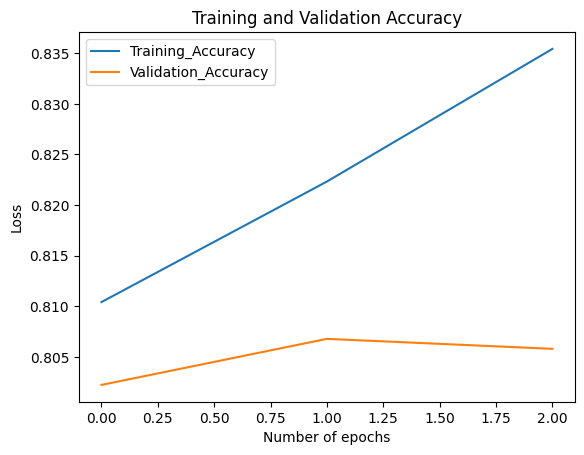

In [134]:
import matplotlib.pyplot as plt

metrics2[["Training_Accuracy", "Validation_Accuracy"]].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

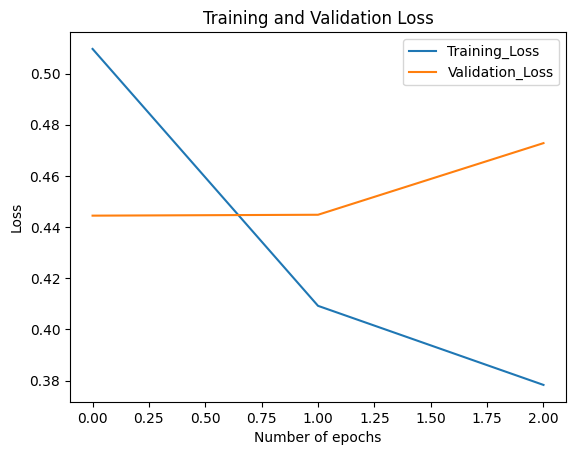

In [135]:
metrics2[["Training_Loss", "Validation_Loss"]].plot()
plt.title('Training and Validation Loss')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

## Bi LSTM Model Evaluation

In [136]:
df7 = df6[["Clean_review", "Helpful"]]
df7.head()

,Clean_review,Helpful
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0
3,nd time staying location one night like first visit check super quick easy pleasant room perfect clean quiet super location finding subway stops back,0
4,wonderfully greeted nakita wanda luigi checked hotel great stay hotel rooms clean showers decent pressure easy us travel around city close multiple subway stations interacted nakita many times throughout trip truly kind caring accommodating great stay would love stay future,0


In [137]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 1000

In [138]:
# Step 5: Evaluate the model
predict_msg = df7["Clean_review"]

new_seq = tokenizer.texts_to_sequences(predict_msg)

padded = pad_sequences(new_seq, maxlen = max_len,
              padding = padding_type,
              truncating=trunc_type)

df7["ypred"]= model2.predict(padded)


2575/2575 [==============================] - 61s 23ms/step


<ipython-input-138-7cede5cb0950>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7["ypred"]= model2.predict(padded)


In [139]:

df7["pred_label"] = np.where(df7["ypred"]>0.5, 1 , 0)

df7.head(3)

,Clean_review,Helpful,ypred,pred_label
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0,0.459397,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1,0.807436,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0,0.334440,0


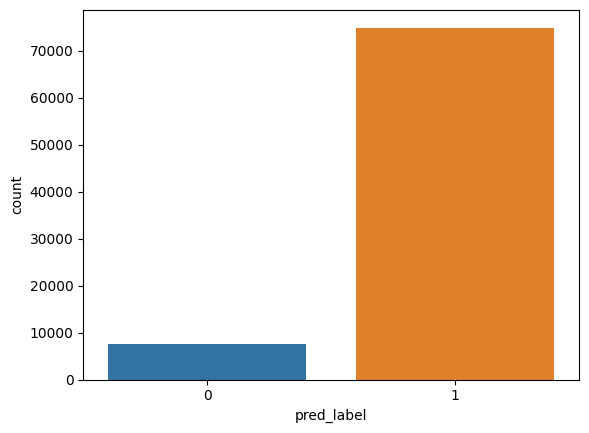

In [140]:
import seaborn as sns

sns.countplot(x="pred_label", data=df7)
plt.show()

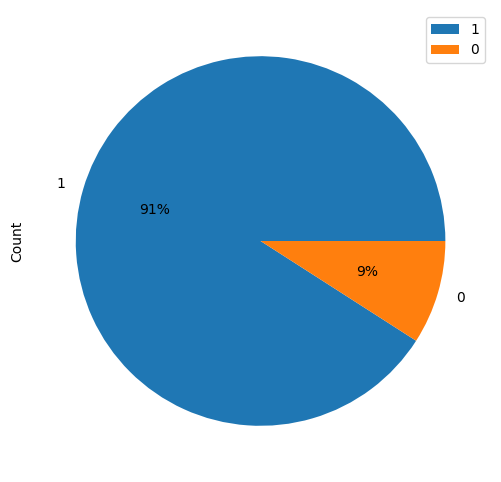

In [141]:
df7['pred_label'].value_counts().to_frame("Count").plot(kind='pie', y='Count', autopct='%1.0f%%', legend= True, figsize = (6,6))
plt.show()

# GRU MODEL

In [228]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [229]:
# Step 2: Build the GRU Model
embedding_dim = 100   # Embedding dimension for word embeddings
gru_units = 64        # Number of units in the GRU layer
max_vocab_size = 1000
max_len = 50

# Define the GRU model with improvements
embedding_dim = 100  # Dimension of the word embeddings
#gru_units = 64  # Number of units in the GRU layer

model3 = Sequential()
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_len))
model3.add(GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Dense(24, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 50, 100)           5884500   
                                                                 
 gru_14 (GRU)                (None, 50, 128)           88320     
                                                                 
 batch_normalization_8 (Batc  (None, 50, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 24)              

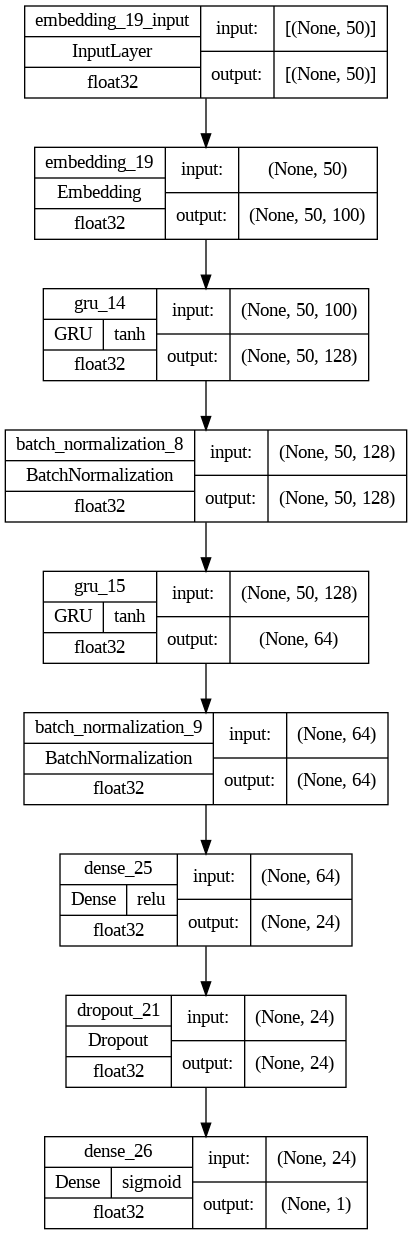

In [230]:
import tensorflow as tf  # Import tensorflow

tf.keras.utils.plot_model(
	model3,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

In [231]:
early_stopping = EarlyStopping(patience=2, restore_best_weights=True)  # Early stopping to prevent overfitting
history3 = model3.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping], shuffle=True)

Epoch 1/20
1648/1648 [==============================] - 123s 72ms/step - loss: 0.6665 - accuracy: 0.7983 - val_loss: 0.5081 - val_accuracy: 0.7989
Epoch 2/20
1648/1648 [==============================] - 117s 71ms/step - loss: 0.4295 - accuracy: 0.8126 - val_loss: 5.0049 - val_accuracy: 0.1983
Epoch 3/20
1648/1648 [==============================] - 116s 70ms/step - loss: 0.3910 - accuracy: 0.8240 - val_loss: 1.6043 - val_accuracy: 0.8017


In [220]:
from tensorflow.python import training

# Evaluate the model
loss_train, accuracy_train = model3.evaluate(X_train, y_train, verbose=False)
loss_test, accuracy_test = model3.evaluate(X_test, y_test, verbose=False)

print("Training loss:", loss_train)
print("Training accuracy:", accuracy_train)
print("Testing loss:", loss_test)
print("Testing accuracy:", accuracy_test)

Training loss: 0.43824687600135803
Training accuracy: 0.8074740767478943
Testing loss: 0.46162086725234985
Testing accuracy: 0.7970627546310425


In [239]:
evaluation_results = {
    'Model': ['GRU_Train', 'GRU_Test'],
    'Loss': [loss_train, loss_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

import pandas as pd

results_df3 = pd.DataFrame(evaluation_results)
results_df3

,Model,Loss,Accuracy
0,GRU_Train,0.438247,0.807474
1,GRU_Test,0.461621,0.797063


In [240]:
metrics3 = pd.DataFrame(history2.history)
metrics3

,loss,accuracy,val_loss,val_accuracy
0,0.509646,0.810416,0.444468,0.802230
1,0.409209,0.822327,0.444814,0.806782
2,0.378291,0.835432,0.472816,0.805796


In [241]:
# Rename column
metrics3.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics3

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.509646,0.810416,0.444468,0.802230
1,0.409209,0.822327,0.444814,0.806782
2,0.378291,0.835432,0.472816,0.805796


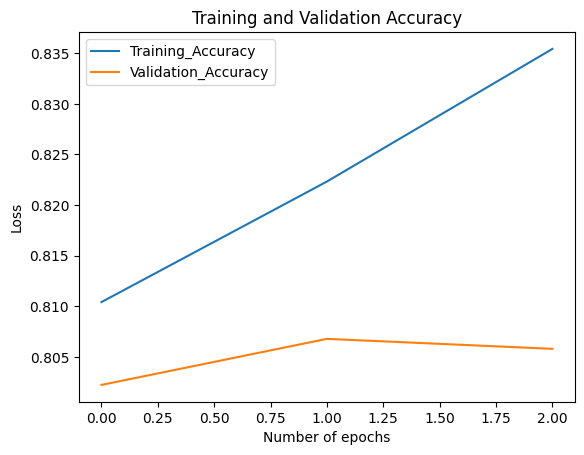

In [242]:
import matplotlib.pyplot as plt

metrics3[["Training_Accuracy", "Validation_Accuracy"]].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

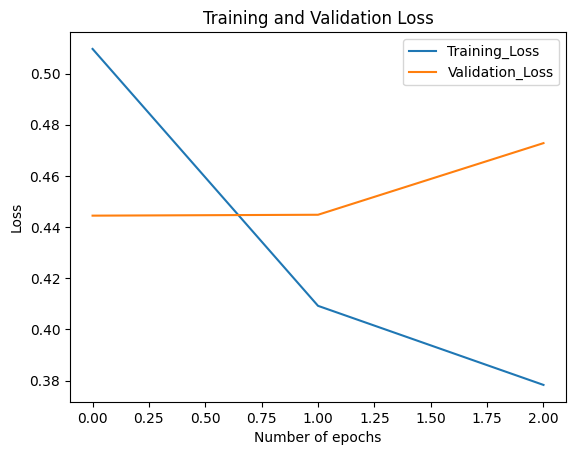

In [243]:
metrics3[["Training_Loss", "Validation_Loss"]].plot()
plt.title('Training and Validation Loss')
plt.xlabel ('Number of epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

# GRU MODEL EVALUATION

In [232]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 10000 # number of unique words in the vocabulary

In [233]:
# Step 5: Evaluate the model
predict_msg = df7["Clean_review"]

new_seq = tokenizer.texts_to_sequences(predict_msg)

padded = pad_sequences(new_seq, maxlen = max_len,
              padding = padding_type,
              truncating=trunc_type)

df8 = df7[["Clean_review", "Helpful"]]

df8["ypred"]= model3.predict(padded)

2575/2575 [==============================] - 41s 16ms/step


<ipython-input-233-80a662683c5f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8["ypred"]= model3.predict(padded)


In [234]:
df8.head(3)

,Clean_review,Helpful,ypred
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0,0.497962
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1,0.629154
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0,0.269220


In [235]:

df8["pred_label"] = np.where(df8["ypred"]>0.5, 1 , 0)

df8.head(3)

,Clean_review,Helpful,ypred,pred_label
0,nice experience hotel anyone would like stay nyc near world trade center choose come nyc also special thanks mrluigi mran msnakita kindness nice hospitality,0,0.497962,0
1,hadnt new york months really long decided stay away midtown picked hotel financial district personnel really nice helpful needs require room clean provided anything requested also helpful subway system hurricane henri flight cancelled accommodating giving extra night room really enjoyed stay,1,0.629154,1
2,wonderful experience entrance exit need shoutout nakita luigi gave warm welcome answered questions wonderful team looking forward next visit,0,0.269220,0


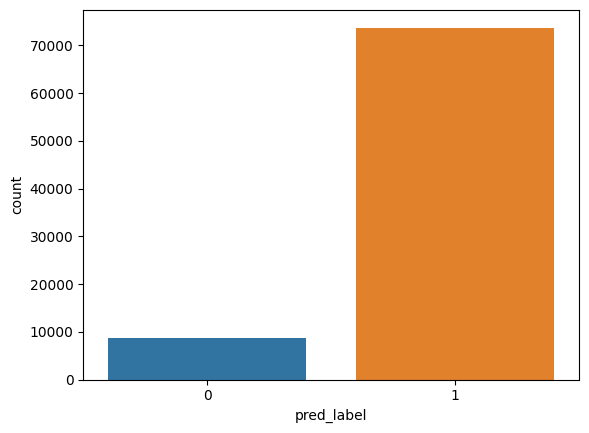

In [236]:
import seaborn as sns

sns.countplot(x="pred_label", data=df8)
plt.show()

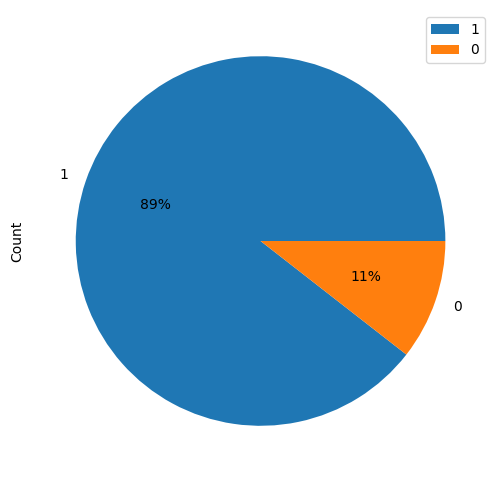

In [237]:
df8['pred_label'].value_counts().to_frame("Count").plot(kind='pie', y='Count', autopct='%1.0f%%', legend= True, figsize = (6,6))
plt.show()